In [1]:
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, fixed, interactive, VBox, HBox
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm

In [11]:
### Change Directory for files ###
file_dir1 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.21'
file_dir2 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.22'
file_dir3 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.23'
file_dir4 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.24'
file_dir5 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.49'
file_dir6 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.50'


### Loads  files ###

### fort.21 ###
specs21 = pd.read_csv(file_dir1, sep=r'\s+', header=None, skiprows=1,
                    names=['$Time$','$Kinetic \ Energy$','$Magnetic \ Energy$','$Correlation \ V \cdot B$','$ Internal \ Energy$','$ρ_{rms}$','$Enstrophy$','$ Magn. \ Enstrophy$','$Temp. Enstrophy$'])
specs21 = specs21.set_index('$Time$')

### fort.22 ###
specs22 = pd.read_csv(file_dir2, sep=r'\s+', header=None, skiprows=1,
                    names=['$V_{a}$','$Time$','$Mach \ Number$','$U_{rms}$','$U_{s}$','$U_{c}$','$Z_{+}$','$Z_{-}$'])
specs22 = specs22.set_index('$Time$')

# fort.23 - needs column names ###
specs23 = pd.read_csv(file_dir3, header=None, skiprows = 3, sep=r'\s+',
                     names = ['$\rho$', '$V_{x}$', '$V_{y}$', '$V_{z}$','$B_{x}$', '$B_{y}$','$B_{z}$','$Temperature$'])

specs23['Bperp'] = np.sqrt(specs23['$B_{y}$']**2 + specs23['$B_{z}$']**2 )

### fort.24 ###
specs24 = pd.read_csv(file_dir4, header=0, skiprows = [1,2],sep=r'\s+')#,
#names = ['densite','temp','u','uc','b','e+','e-','ev-eb','e+-e-'])


### fort.49 ###
specs49 = pd.read_csv(file_dir5, sep=r'\s+', header=None)#,
#                    names = ['?','??','???','????'])

### fort.50 ###
specs50= pd.read_csv(file_dir6, sep=r'\s+', header=None, names = ['Temperature', 'Density', 'By', 'Bz'])

# Define functions


In [2]:

def waterfall_plot(fig,ax,who,X1,Y1,Z1,zlog):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
    '''
    # Set normalization to the same values for all plots
    X = X1
    Y = Y1
    Z = Z1[who]

    norm = plt.Normalize(min(Z.reshape(np.size(Z),1)), max(Z.reshape(np.size(Z),1)))

    # reshape the X,Z into pairs 
    points = np.array([X, Z]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)   
    if zlog ==1:
        lc = LineCollection(segments, cmap='plasma', norm=LogNorm())
    else:
        lc = LineCollection(segments, cmap='plasma', norm=norm)
    # Set the values used for colormapping
    lc.set_array((Z[1:]+Z[:-1])/2)
    lc.set_linewidth(2) # set linewidth a little larger to see properly the colormap variation
    line = ax.add_collection3d(lc,zs=(Y[1:]+Y[:-1])/2, zdir='y') # add line to axes
    
    

def sequential_3D(choose_column, quant, resolution,
                  t_steps,zmax1,zmin ,zmax,zlog,
                  save_3D_movie,fig_size,every_n_tstep,two_plots,fig,save_folder,
                  save_folder2,save_screenshot,elev=30., azim=150):  
    quantity = choose_column
    col     = ['Density', '$V_{x}$', '$V_{y}$', '$V_{z}$','$B_{x}$', '$B_{y}$','$B_{z}$','$Temperature$']
      
    # Make data.
    X     = np.arange(0, resolution, 1)
    Y     = np.arange(0, int(len(choose_file)/resolution),1)
    X, Y  = np.meshgrid(X, Y)
    Z     = choose_file[column[quant]].values
    new_z = np.zeros((t_steps,resolution))   # Selected quantity as a function of x,t
    
    ###  Plot figure ###

    for i in range(0,int(len(choose_file)/resolution)):
        new_z[i] = choose_column[i*resolution+i:resolution*(i+1)+i].values
    if two_plots:
        fig = fig
        ax  = fig.add_subplot(2, 1, 1, projection='3d')
        
    else:
        fig = plt.figure(figsize=fig_size)
        ax  = fig.add_subplot(111,projection='3d')
        
    bounds_min = min(new_z.reshape(np.size(new_z),1))
    bounds_max = max(new_z.reshape(np.size(new_z),1))

    # setup colorbar stuff
    # get bounds of colors
    if zlog:
        norm = LogNorm(vmin =bounds_min , vmax =bounds_max)
    else:
        norm = plt.cm.colors.Normalize(bounds_min, bounds_max)
    
    cmap = plt.cm.plasma
    # setup scalar mappable for colorbar
    sm   = plt.cm.ScalarMappable(norm, plt.cm.plasma)

    for i in range(0,t_steps,every_n_tsteps):    # Plot only first 10 lines for testing
        x = X[i]
        y = Y[i]
        z = new_z
        threed1 = waterfall_plot(fig,ax,i,x,y,z,zlog)
        
         ### Axes properties ###
            
        ax.set_xlabel('X') ; ax.set_xlim3d(0,resolution); ax.set_xlabel('X point')
        ax.set_ylabel('Y') ; ax.set_ylim3d(0,t_steps) ; ax.set_ylabel('Timestep')
        ax.set_zlabel('Z') ; ax.set_zlim3d(bounds_min, bounds_max); ax.set_zlabel(col[quant])
        ax.view_init(elev=elev, azim=azim)
        if i ==0:
            fig.colorbar(sm, shrink=0.5) 
        if save_screenshot:
            fig.savefig(save_folder% i, format='jpg',dpi=300,bbox_inches='tight')

    #plt.title('$Evolution  \ of  \ '+col[quant]+$', fontsize =24) ### column here
    
    #fig.colorbar(ax)
    plt.colorbar(sm, shrink=0.5)  
    fig.subplots_adjust(top=0.98)
    if save_3D_movie:
      ### Save 3D images ###
        for ii in range(0,360,40):
            ax.view_init(elev=20., azim=ii)
            fig.savefig(save_folder% ii, format='jpg',dpi=300,bbox_inches='tight')
    else:
            fig.savefig(save_folder, format='jpg',dpi=300,bbox_inches='tight')
    

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

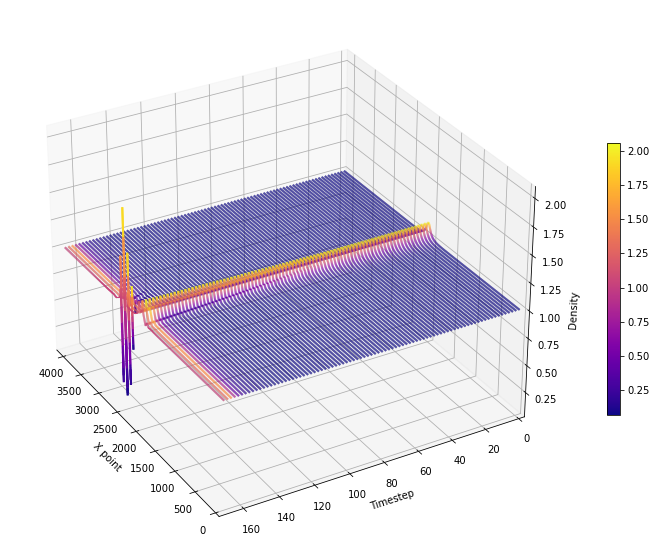

In [8]:
two_plots       = False

if two_plots:
    # Set up a figure twice as tall as it is wide
    fig = plt.figure(figsize=plt.figaspect(2))
    #fig.suptitle('A tale of 2 subplots')
else:
    fig = plt.figure()

### First subplot ###

choose_file     = specs23                       # Choose file betwenn specs21, specs22,...

quant           = 0                           # Choose between 0,1,...,according to the following list

column          = ['$\rho$', '$V_{x}$',  '$V_{y}$',
                   '$V_{z}$', '$B_{x}$', '$B_{y}$',
                   '$B_{z}$',     '$Temperature$']

choose_column   = choose_file[column[quant]] 

resolution      = len(specs50)                      # Specify resolution of grid in MHD simulation
t_steps         = int(len(choose_file)/resolution)   # Specify number of timesteps in MHD simulation

zmax1           = 0
zmax            = 1.5                                # Max value in z axis
zmin            = 0.8                                # Min value in z axis
zlog            = 0                                  # Log norm in colormap or not?
fig_size        = (20, 10)                           # Select figure size ( keep constant)
every_n_tsteps  = 2                                  # Plot lines every n steps
save_3D_movie   = False                              # Save figure from diferent angles
save_screenshot = True
every_n_tstep   =  3


if resolution == 2048:
    save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\formovie\_3d_density%d.jpg' ## change here
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\formovie\_sequent%d.jpg' ## change here
elif resolution == 1024:
    save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\formovie\_3d_density%d.jpg' ## change here 
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\formovie\_sequent%d.jpg' ## change here

else:
    save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\formovie\_3d_density%d.jpg' ## change here 
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\formovie\_sequent%d.jpg' ## change here



sequential_3D(choose_column, quant, resolution,
                  t_steps,zmax1,zmin ,zmax,zlog,
                  save_3D_movie,fig_size,every_n_tstep,two_plots,fig,save_folder,
                  save_folder2,save_screenshot,elev=30., azim=150)

### Second subplot ###
if two_plots:
    ax = fig.add_subplot(2, 1, 2)
    
    if resolution == 2048:
        save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\_3d_bz%d.jpg' ## change here
    else:
        save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\_3d_bz%d.jpg' ## change here 

    for kk in range(0,t_steps,every_n_tsteps):
        ax.plot(np.arange(0,resolution),choose_column[kk*(resolution):(kk+1)*resolution])
    #fig.savefig(save_folder% kk, format='jpg',dpi=300,bbox_inches='tight')
    #fig.show()     
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.image as mpimg
%matplotlib notebook

#save_folder2     = r'C:\Users\nikos.000\MHD1D\figures\jpg\test1\_3d_density%d.jpg' ## change here 
#save_folder3     = r'C:\Users\nikos.000\MHD1D\figures\jpg\test1\_3d_density' ## change here 

if resolution == 2048:
    save_folder2    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\formovie\_3d_density%d.jpg' ## change here
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\movie\_3d_density' ## change here
elif resolution == 1024:
    save_folder2    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\formovie\_3d_density%d.jpg' ## change here 
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\movie\_3d_density'## change here

else :
    save_folder2    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\formovie\_3d_density%d.jpg' ## change here 
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\movie\_3d_density'## change here




steps = np.arange(0,t_steps,every_n_tsteps)
img = []
for k in steps:
    img.append(mpimg.imread(save_folder2% k) ) #path file
                         
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(len(img)):
    frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True, aspect='auto')])

ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=1000)

plt.axis('off')
#ani.save(save_folder3+'.mp4', bbox_inches='tight')
ani.save(save_folder3+'.gif', savefig_kwargs = dict(transparent = False))
plt.show()


In [3]:

def subpl_23(input_df, column,every_n_tsteps,ymax1,ymax, n_rows,n_cols, 
             fig_size,save_folder,save_screenshot,colorbar,zlog,sharex=True,sharey= False):
    
    column1          = ['$ρ(x,τ)$', '$V_{x}(x,τ)$',  '$V_{y}(x,τ)$',
                   '$V_{z}(x,τ)$', '$B_{\perp}(x,τ)$', '$B_{y}(x,τ)$',
                   '$B_{z}(x,τ)$',     '$T(x,τ)$']

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=False,sharex=sharex, figsize=fig_size)
    fig.subplots_adjust(hspace = .25, wspace=.15)

    # Number of subplots
    
    dt1  = n_rows*n_cols
    data = np.arange(0, dt1)
    x    = np.arange(0,resolution)
    for kk in range(0,t_steps,every_n_tsteps):
        
        first_time =0    # Show colorbar only the first time
        for ax, i in zip(axs.ravel(), data):
            ax.cla() # or ax.clear()
            if i== 4:
                ax.plot(np.arange(0,resolution),input_df[column[-1]][0*(resolution):(1)*resolution],color = 'black',ls='--' ,label = '$τ \  = \ 0$')
                ax.set_title(column1[i],fontsize=20)
            else:
                ax.plot(np.arange(0,resolution),input_df[column[i]][0*(resolution):(1)*resolution],color = 'black',ls='--' ,label = '$τ \  = \ 0$')
                ax.set_title(column1[i],fontsize=20)                    
            if kk>0:
                if i== 4:
                    y = input_df[column[-1]][kk*(resolution)+kk:(kk+1)*resolution+kk]
                else:
                    y = input_df[column[i]][kk*(resolution)+kk:(kk+1)*resolution+kk]
                if i ==0:
                    ymax1, ymax,ymin = False, 1.8, 0.5
                    
                else: 
                    ymax1, ymax,ymin = False, 1.8, 0.5
                Y = input_df[column[i]]
                waterfall_plot_2D(fig,ax,x,y,zlog, ymax1, ymax,ymin, colorbar,first_time)
                ax.set_title(column1[i],fontsize=20)
                first_time+=1
                
            ax.legend(frameon=False,loc=1,fontsize=15) 
            ax.tick_params(axis='both',labelsize=15)
            ax.grid()
            fig.suptitle("$Time =$ {}".format(specs21.index[kk]),fontsize=25)
        if save_screenshot:
            
            fig.savefig(save_folder% kk, format='jpg',dpi=300,bbox_inches='tight')
            
            
    plt.xlabel('$Time$',fontsize=18)
        

In [4]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm


def waterfall_plot_2D(fig,ax,X1,Y1,zlog, ymax1, ymax,ymin, colorbar,first_time):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        X,Y : n,m array
    '''
    # Set normalization to the same values for all plots
    X = X1
    Y = Y1


    norm = plt.Normalize(min(Y), max(Y))
    
    # reshape the X,Y into pairs 
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)   
    if zlog ==1:
        lc = LineCollection(segments, cmap='RdYlBu_r', norm=LogNorm(vmin =min(Y), vmax =max(Y)))
    else:
        lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
    # Set the values used for colormapping
    lc.set_array(Y)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    if colorbar:
        axbox  = ax.get_position()
        cbaxes = fig.add_axes([0.13, 0.68, 0.02, 0.17])
    ax.set_xlim([0,resolution])
    ax.set_ylim([min(Y)-0.25*1e-1*abs(min(Y)), max(Y) + 0.25*1e-1*abs(max(Y))])
    #ax.set_ylim([min(Y[Y>-1e10])-1e-2*abs(max(Y[Y>-1e10])), max(Y[Y>-1e10])+1e-2*abs(max(Y[Y>-1e10]))])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    

<IPython.core.display.Javascript object>


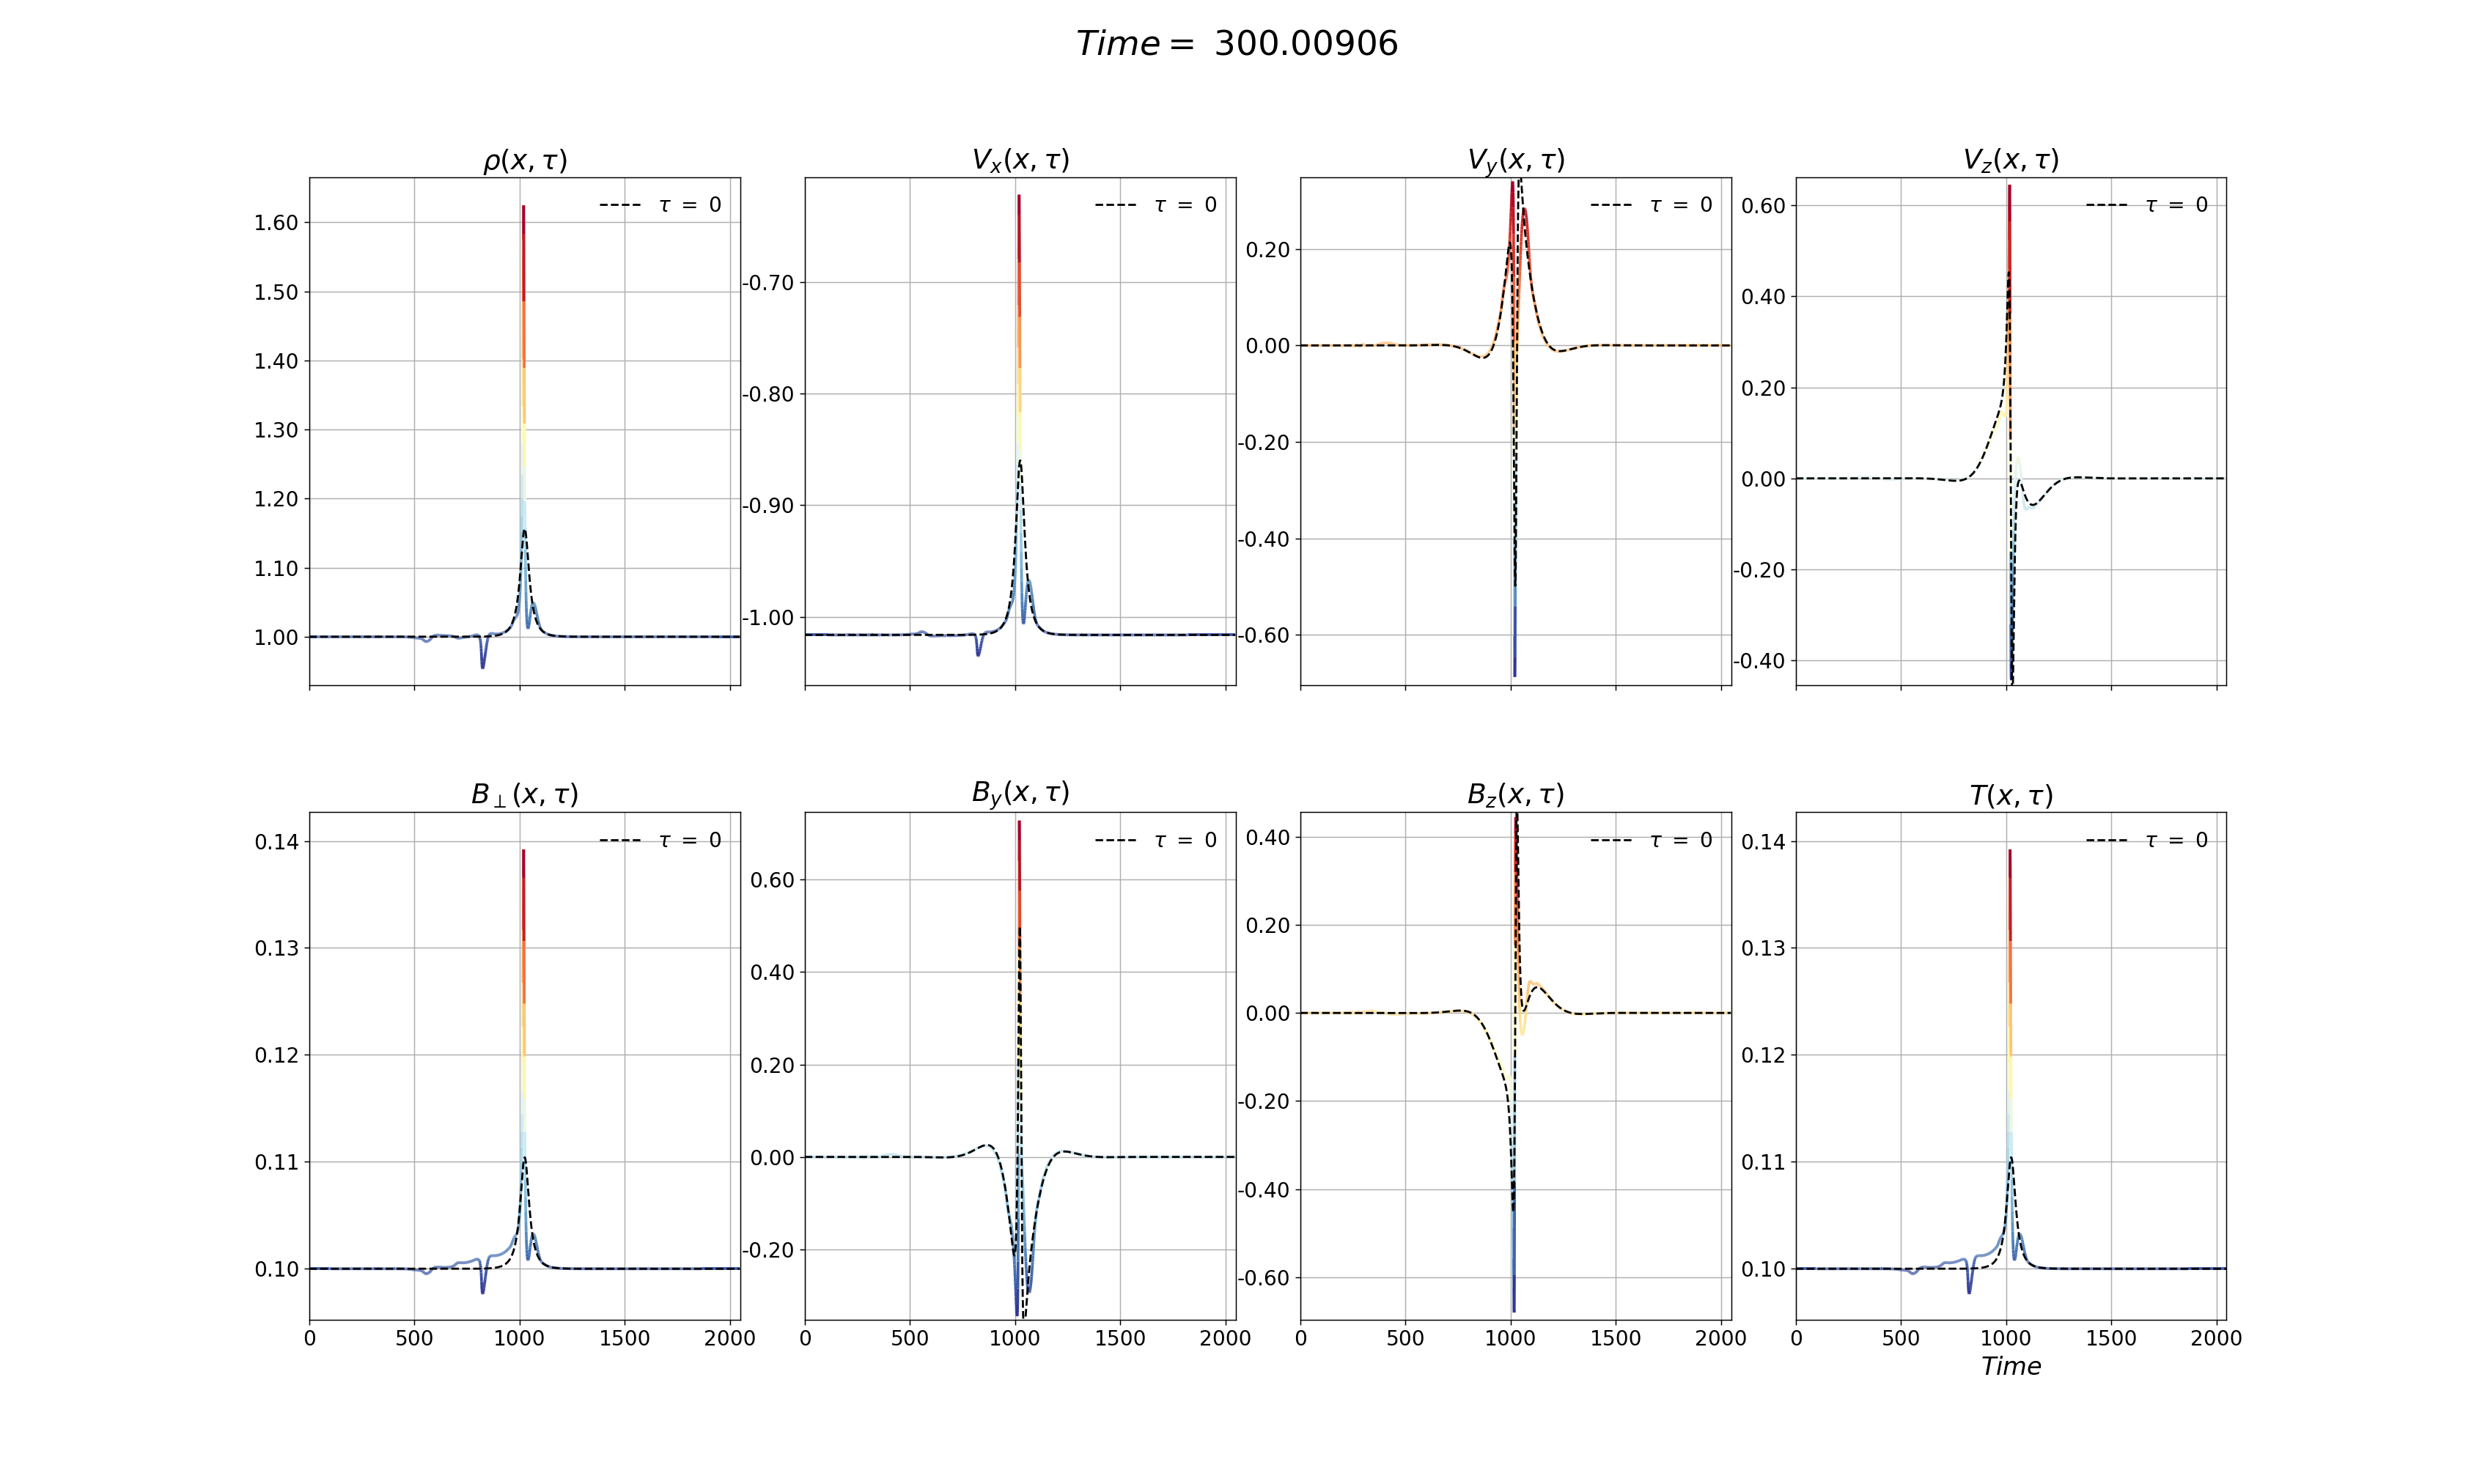

In [502]:
# from matplotlib.ticker import FormatStrFormatter

beta             =  0.22
choose_file      = specs23                            # Choose file betwenn specs21, specs22,...

quant            = 0                                  # Choose between 0,1,...,according to the following list

column           = ['$\rho$', '$V_{x}$',  '$V_{y}$',
                   '$V_{z}$', '$B_{x}$', '$B_{y}$',
                   '$B_{z}$',     '$Temperature$']

choose_column    = choose_file[column[quant]] 

resolution       = len(specs50)                       # Specify resolution of grid in MHD simulation
t_steps          = int(len(choose_file)/resolution)   # Specify number of timesteps in MHD simulation
fig_size         = (25,15)
n_rows,n_cols    = 2,4
every_n_tsteps   = 4                                  # Plot lines every n steps
ymax1            = False
ymax             = 1.8
zlog             = False
save_folder      = r'C:\Users\nikos.000\MHD1D\figures\jpg\test1\_secs23_2D%d.jpg' ## change here

if resolution == 2048:
    save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here   
elif resolution == 1024:
    save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here 
else:
    save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here 
    
    
    
colorbar           = False
save_screenshot    = True
sharey             = False



subpl_23(choose_file, column,every_n_tsteps,ymax1,ymax, n_rows,n_cols, fig_size, save_folder, save_screenshot,colorbar,zlog, sharex=True,sharey= False)

### Create specs23 movie

<IPython.core.display.Javascript object>


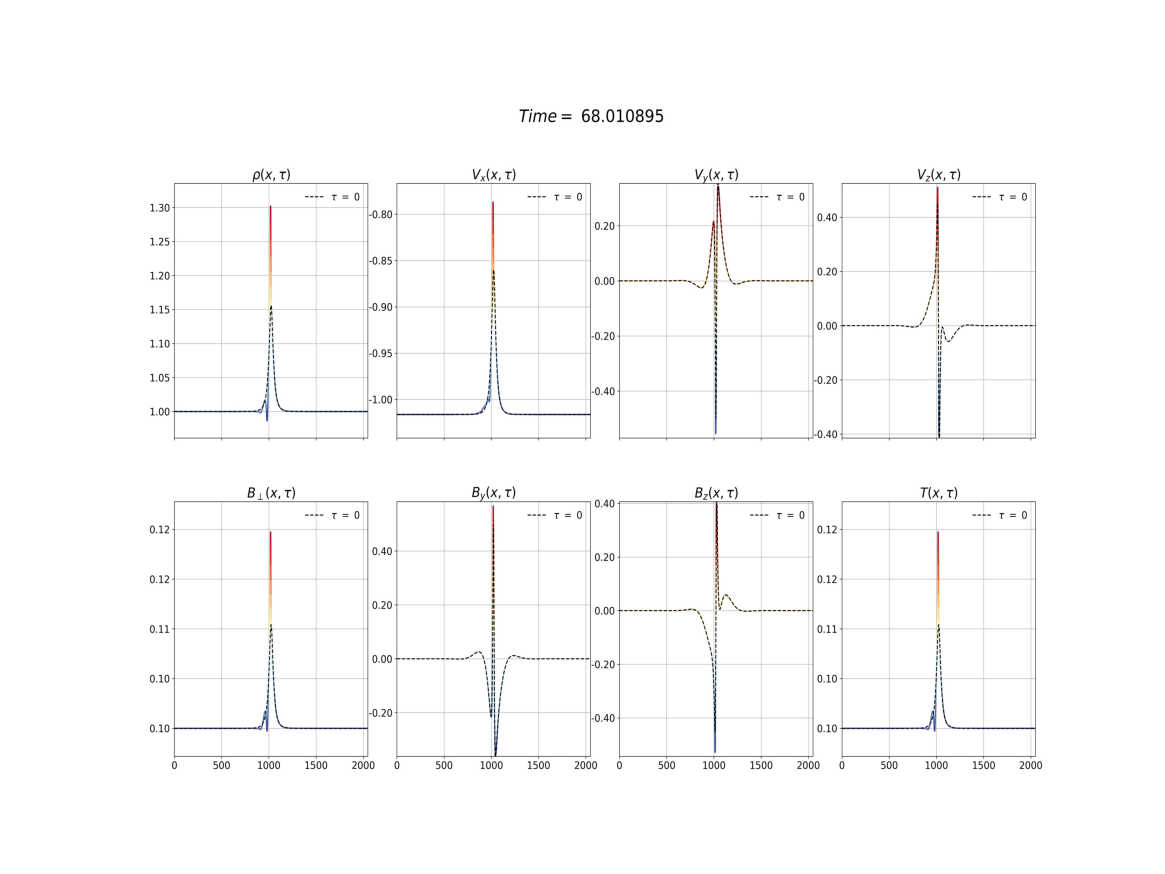

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.image as mpimg
%matplotlib notebook

resolution =2048
beta = 0.22
#= r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg'

if resolution == 2048:
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\movie\_beta_'+str(beta)+'spec23_mov' ## change here
elif resolution == 1024 :
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here 
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\movie\_beta_'+str(beta)+'spec23_mov' ## change here
else:
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here 
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\movie\_beta_'+str(beta)+'spec23_mov' ## change here



every_n_tsteps =8
steps = np.arange(0,t_steps,every_n_tsteps)
img = []
for k in steps:
    img.append(mpimg.imread(save_folder2% k) ) #path file
                         
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(len(img)):
    frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True, aspect='auto')])

ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=200000)

plt.axis('off')
#ani.save(save_folder3+'.mp4', bbox_inches='tight')
ani.save(save_folder3+'.gif',dpi=300, savefig_kwargs = dict(transparent = False))
plt.show()

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.image as mpimg
%matplotlib notebook

resolution =2048
beta = 0.22
#= r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg'

if resolution == 2048:
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_2048\final\movie\_beta_'+str(beta)+'spec23_mov' ## change here
elif resolution == 1024 :
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here 
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_1024\final\movie\_beta_'+str(beta)+'spec23_mov' ## change here
else:
    save_folder2   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\formovie\_beta_'+str(beta)+'secs23_2D%d.jpg' ## change here 
    save_folder3   = r'C:\Users\nikos.000\MHD1D\figures\jpg\res_4096\final\movie\_beta_'+str(beta)+'spec23_mov' ## change here



every_n_tsteps =8
steps = np.arange(0,t_steps,every_n_tsteps)
img = []
for k in steps:
    img.append(mpimg.imread(save_folder2% k) ) #path file
                         
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(len(img)):
    frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True, aspect='auto')])

ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True,
                                repeat_delay=200000)

plt.axis('off')
#ani.save(save_folder3+'.mp4', bbox_inches='tight')
ani.save(save_folder3+'.gif',dpi=300, savefig_kwargs = dict(transparent = False))
plt.show()

NameError: name 't_steps' is not defined

### This one looks good too:

In [19]:
### Change Directory for files ###
file_dir1 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.21'
file_dir2 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.22'
file_dir3 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.23'
file_dir4 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.24'
file_dir5 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.49'
file_dir6 = r'C:\Users\nokni\OneDrive\Υπολογιστής\NewMHD1D\MHD_298\fort.50'


### Loads  files ###

### fort.21 ###
specs21 = pd.read_csv(file_dir1, sep=r'\s+', header=None, skiprows=1,
                    names=['$Time$','$Kinetic \ Energy$','$Magnetic \ Energy$','$Correlation \ V \cdot B$','$ Internal \ Energy$','$ρ_{rms}$','$Enstrophy$','$ Magn. \ Enstrophy$','$Temp. Enstrophy$'])
specs21 = specs21.set_index('$Time$')

### fort.22 ###
specs22 = pd.read_csv(file_dir2, sep=r'\s+', header=None, skiprows=1,
                    names=['$V_{a}$','$Time$','$Mach \ Number$','$U_{rms}$','$U_{s}$','$U_{c}$','$Z_{+}$','$Z_{-}$'])
specs22 = specs22.set_index('$Time$')

# fort.23 - needs column names ###
specs23 = pd.read_csv(file_dir3, header=None, skiprows = 3, sep=r'\s+',
                     names = ['$\rho$', '$V_{x}$', '$V_{y}$', '$V_{z}$','$B_{x}$', '$B_{y}$','$B_{z}$','$Temperature$'])

specs23['Bperp'] = np.sqrt(specs23['$B_{y}$']**2 + specs23['$B_{z}$']**2 )

### fort.24 ###
specs24 = pd.read_csv(file_dir4, header=0, skiprows = [1,2],sep=r'\s+')#,
#names = ['densite','temp','u','uc','b','e+','e-','ev-eb','e+-e-'])


### fort.49 ###
specs49 = pd.read_csv(file_dir5, sep=r'\s+', header=None)#,
#                    names = ['?','??','???','????'])

### fort.50 ###
specs50= pd.read_csv(file_dir6, sep=r'\s+', header=None, names = ['Temperature', 'Density', 'By', 'Bz'])

<IPython.core.display.Javascript object>


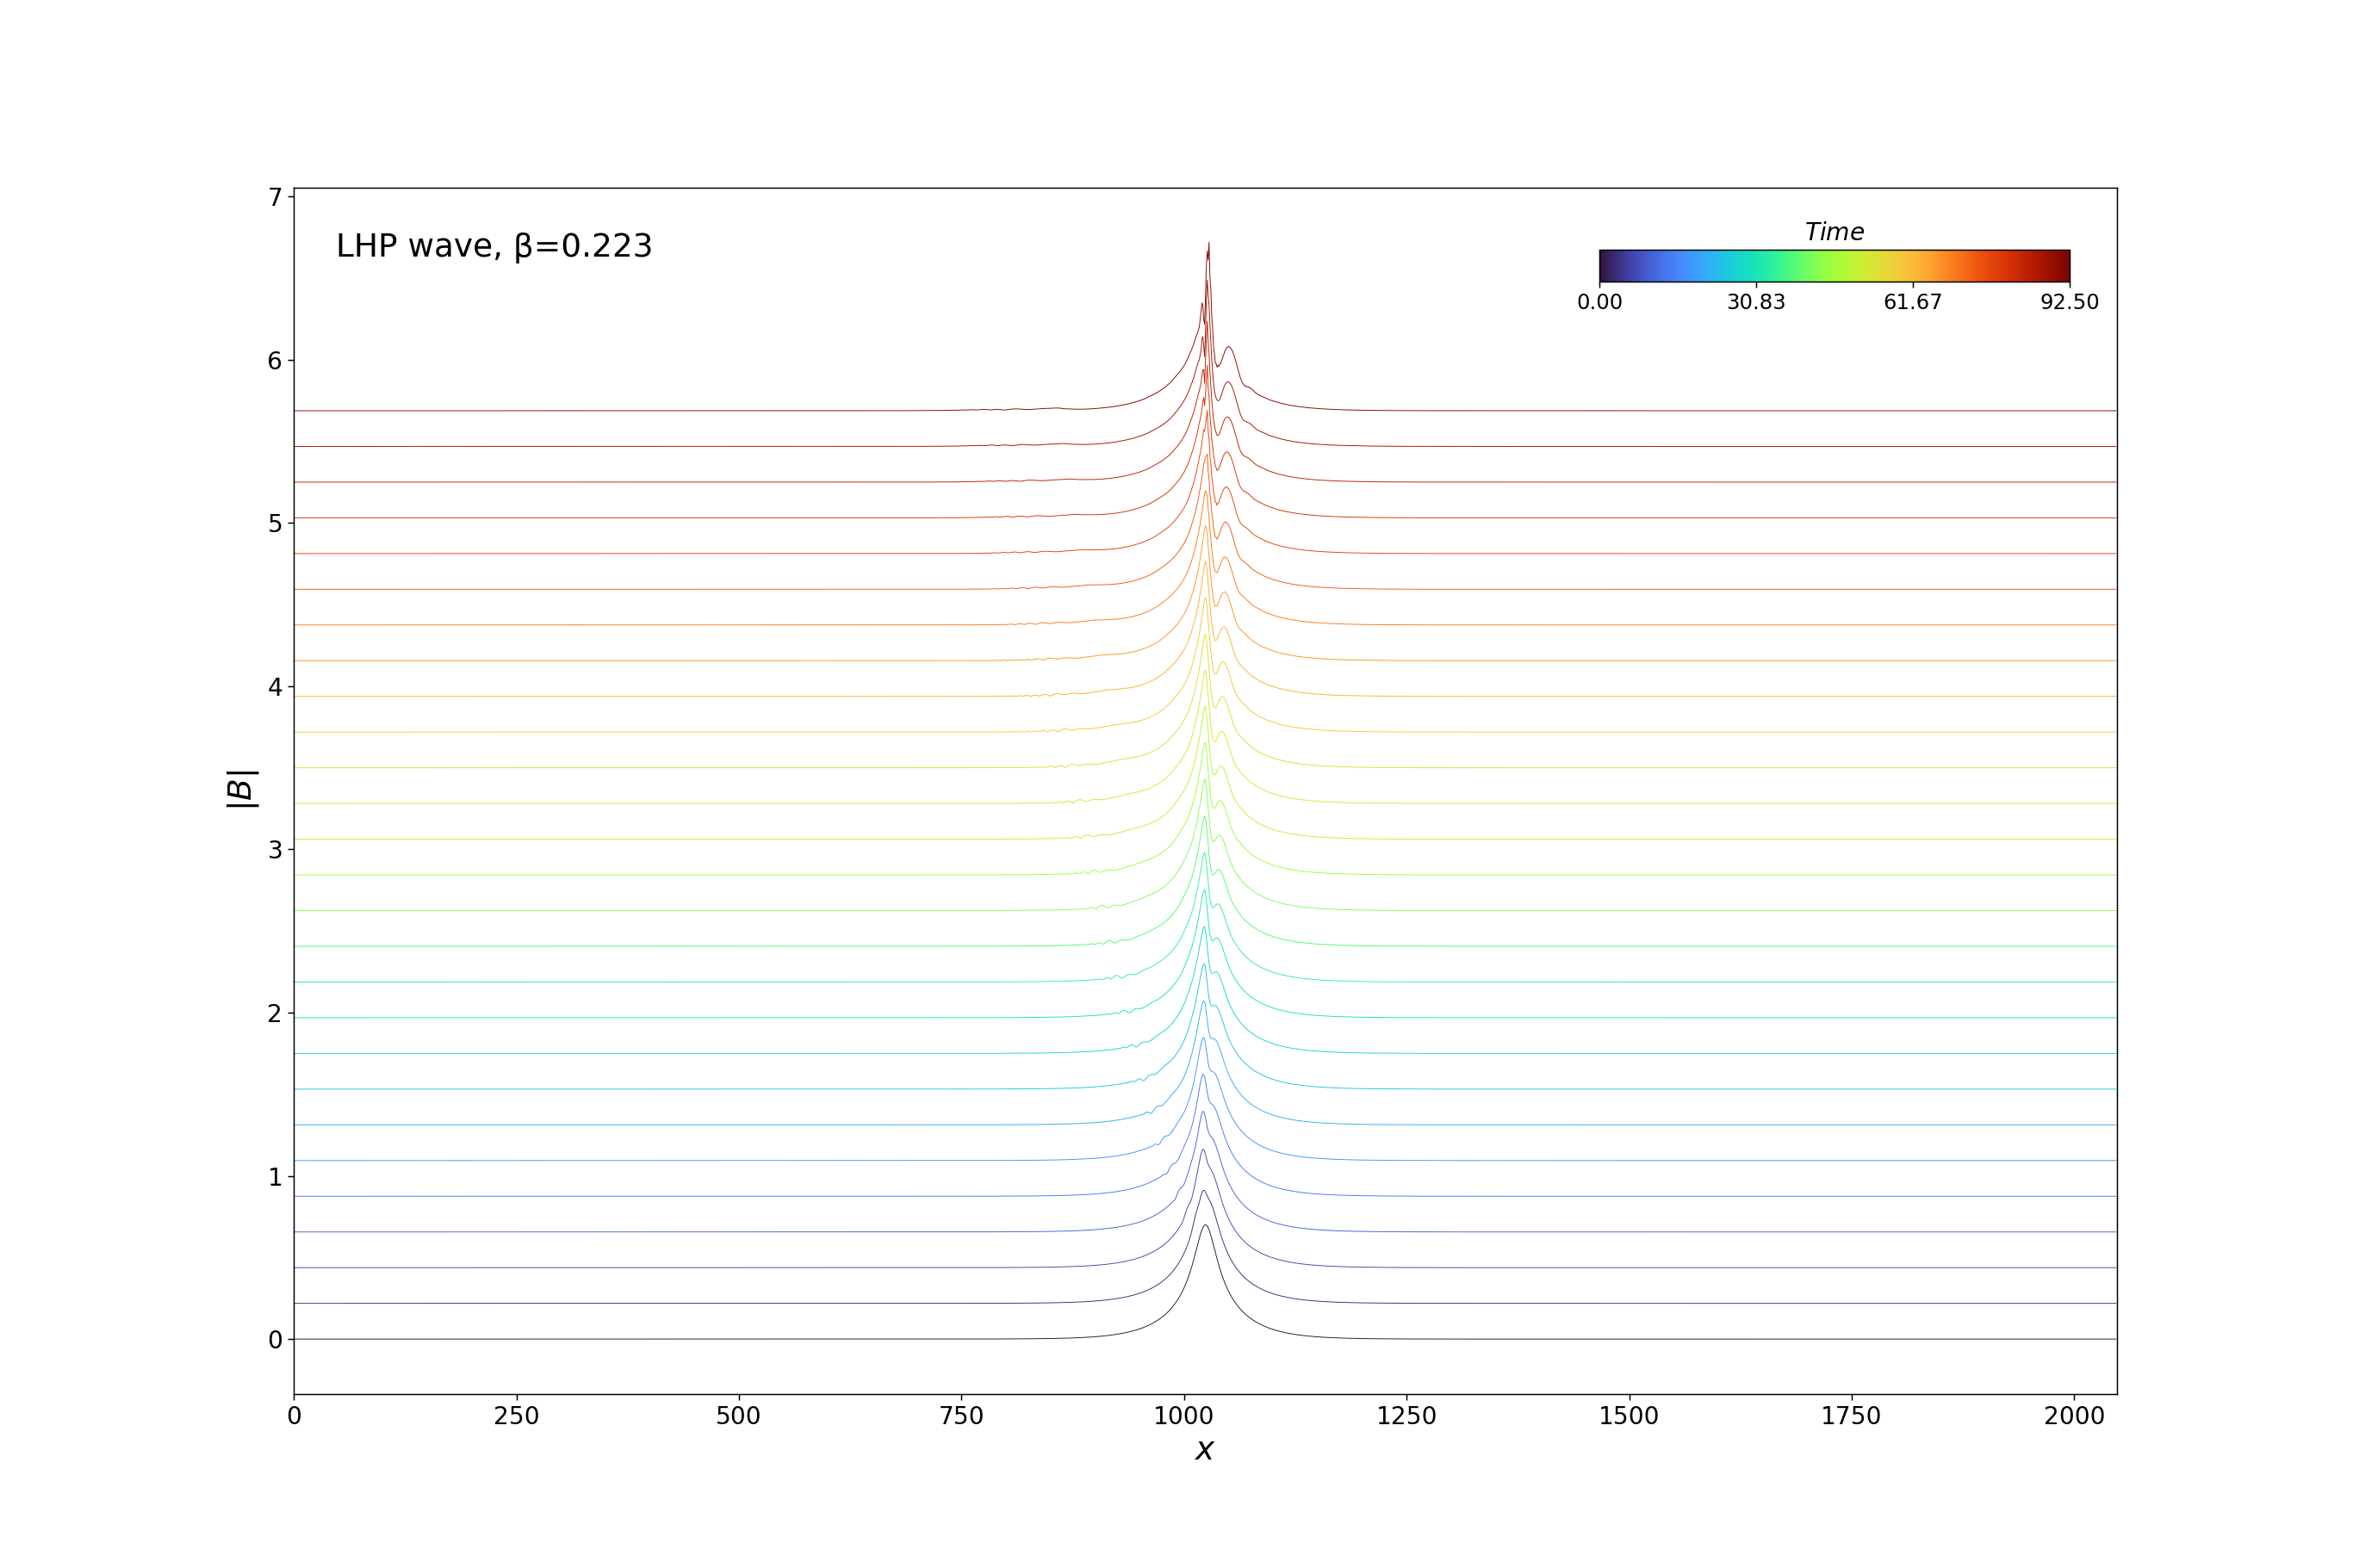

In [20]:
import matplotlib.pylab as plt
import matplotlib.colors 
import matplotlib as mpl
import seaborn as sns

### Change the parameters here to save the file ###
polar = 'LHP_waveb_'
polara = 'LHP wave, β='
beta  = 0.223
BS    = 0.5

choose_file      = specs23                            # Choose file betwenn specs21, specs22,...

quant            = 0                                  # Choose between 0,1,...,according to the following list

column           = ['$\rho$', '$V_{x}$',  '$V_{y}$',
                   '$V_{z}$', '$B_{x}$', '$B_{y}$',
                   '$B_{z}$',     '$Temperature$']

choose_column    = choose_file[column[quant]] 

resolution       = len(specs50)                       # Specify resolution of grid in MHD simulation
t_steps          = int(len(choose_file)/resolution)   # Specify number of timesteps in MHD simulation
fig_size         = (25,15)
n_rows,n_cols    = 2,4
every_n_tsteps   = 7                                 # Plot lines every n steps
hm               = 32

fig = plt.figure( figsize=(15,10))
ax = fig.add_subplot()
save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\_test'
new = np.arange(0,t_steps,every_n_tsteps)

### Add colorbar ###

cmap = mpl.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin = specs21.index.min(), vmax = specs21.index.max(), clip = False), cmap=mpl.cm.turbo)
c    = np.linspace(specs21.index.min(),specs21.index.max(),len(specs21))


for kk in range(0,t_steps,every_n_tsteps):
    #if kk ==new[-1]:
        #ax.plot(np.arange(0,resolution),specs23['Bperp'][kk*(resolution)+kk:(kk+1)*resolution+kk]+kk/hm, color=cmap.to_rgba(c[kk]),linewidth=0.5,label=polar+str(beta))
    ax.plot(np.arange(0,resolution),specs23['Bperp'][kk*(resolution)+kk:(kk+1)*resolution+kk]+kk/hm, color=cmap.to_rgba(c[kk]),linewidth=0.5)

    
### Set color bar position  and size, label###

axbox = ax.get_position()
cbaxes = fig.add_axes([0.68, 0.82, 0.2, 0.02]) 
cbar=fig.colorbar(cmap, cax=cbaxes, ticks=c, orientation='horizontal', pad=5)
cbar.set_ticks(np.linspace(specs21.index.min(),specs21.index.max(),4))
cbar.ax.set_title('$Time$', fontsize=15 )
cbar.ax.tick_params(labelsize=13)
    
    
### Add text ###

ax.text(0.11, 0.95,polara+str(beta),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,fontsize =20)
    
ax.set_xlim(0,resolution) 
#ax.legend(frameon=False,loc=2,fontsize=15) 
ax.tick_params(axis='both',labelsize=15)
ax.set_xlabel('$x$',fontsize =20)
ax.set_ylabel('$|B|$',fontsize =20)
#fig.colorbar(cmap)
fig.show()     
fig.savefig(save_folder+polar+str(beta)+str(BS)+'.jpg', format='jpg',dpi=300,bbox_inches='tight')
    

# Find $B_{max}$ at each timestep

### Create DF's -- plot temporary figures

<IPython.core.display.Javascript object>


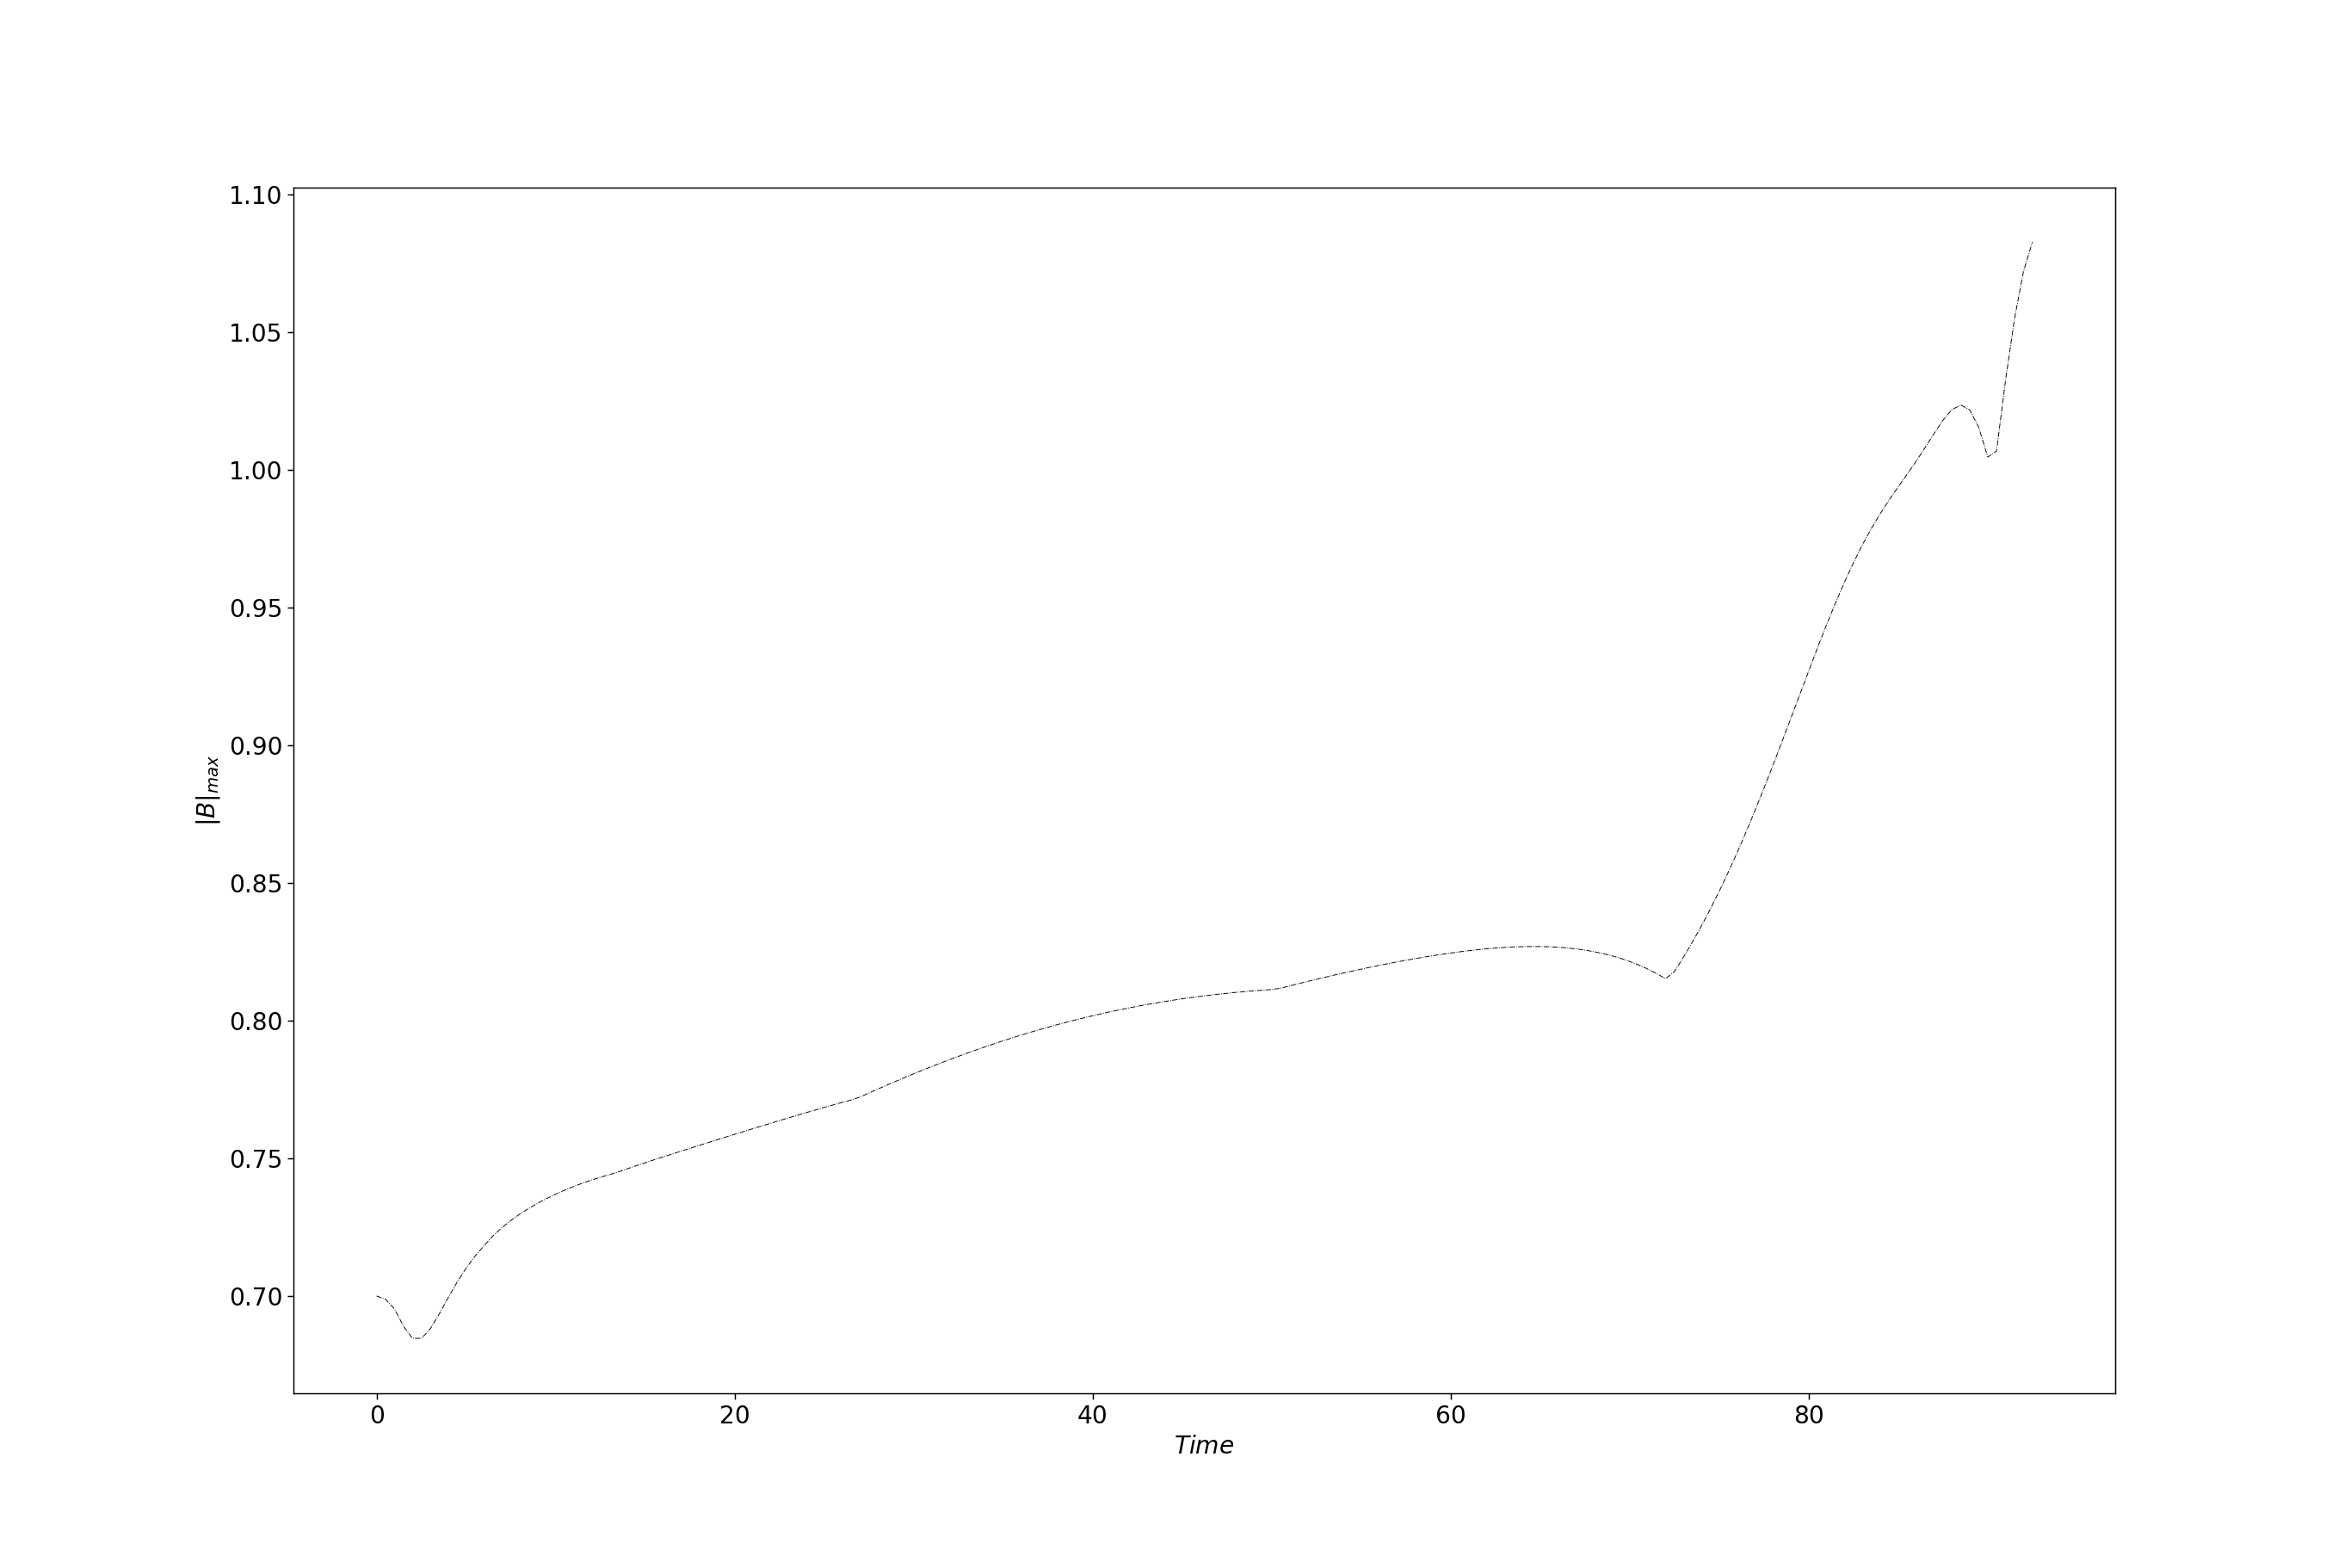

No handles with labels found to put in legend.


In [21]:
save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\_Bmax_'
choose_file      = specs23                            # Choose file betwenn specs21, specs22,...

quant            = 0                                  # Choose between 0,1,...,according to the following list

column           = ['$\rho$', '$V_{x}$',  '$V_{y}$',
                   '$V_{z}$', '$B_{x}$', '$B_{y}$',
                   '$B_{z}$',     '$Temperature$']

choose_column    = choose_file[column[quant]] 

resolution       = len(specs50)                       # Specify resolution of grid in MHD simulation
t_steps          = int(len(choose_file)/resolution)   # Specify number of timesteps in MHD simulation
fig_size         = (25,15)
n_rows,n_cols    = 2,4
every_n_tsteps   = 1                                 # Plot lines every n steps
hm               = 64

fig = plt.figure( figsize=(15,10))
ax = fig.add_subplot()
save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\_test'
dir1           = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\dfs_bmax\_'+polar+str(beta)+str(BS)+'.csv'
new  = np.arange(0,t_steps,every_n_tsteps)
Bmax = np.zeros(len(specs21))
time_Bmax = specs21.index.values
for kk in range(0,t_steps):
    Bmax[kk] = specs23['Bperp'][kk*(resolution)+kk:(kk+1)*resolution+kk].max()
    
    

ax.plot(time_Bmax,Bmax, color = 'black',ls='-.',linewidth=0.5)

ax.legend(frameon=False,loc=1,fontsize=15) 
ax.tick_params(axis='both',labelsize=15)
ax.set_xlabel('$Time$',fontsize =15)
ax.set_ylabel('$|B|_{max}$',fontsize =15)

fig.show()     
fig.savefig(save_folder+polar+str(beta)+str(BS)+'.jpg', format='jpg',dpi=300,bbox_inches='tight')

Bmax_df = pd.DataFrame({'Time' :time_Bmax,
                        'Bmax' :  Bmax})   


Bmax_df.to_csv(dir1)  
 
    

### Load DataFrame's - Create figure 6 from Buti et al.

<IPython.core.display.Javascript object>


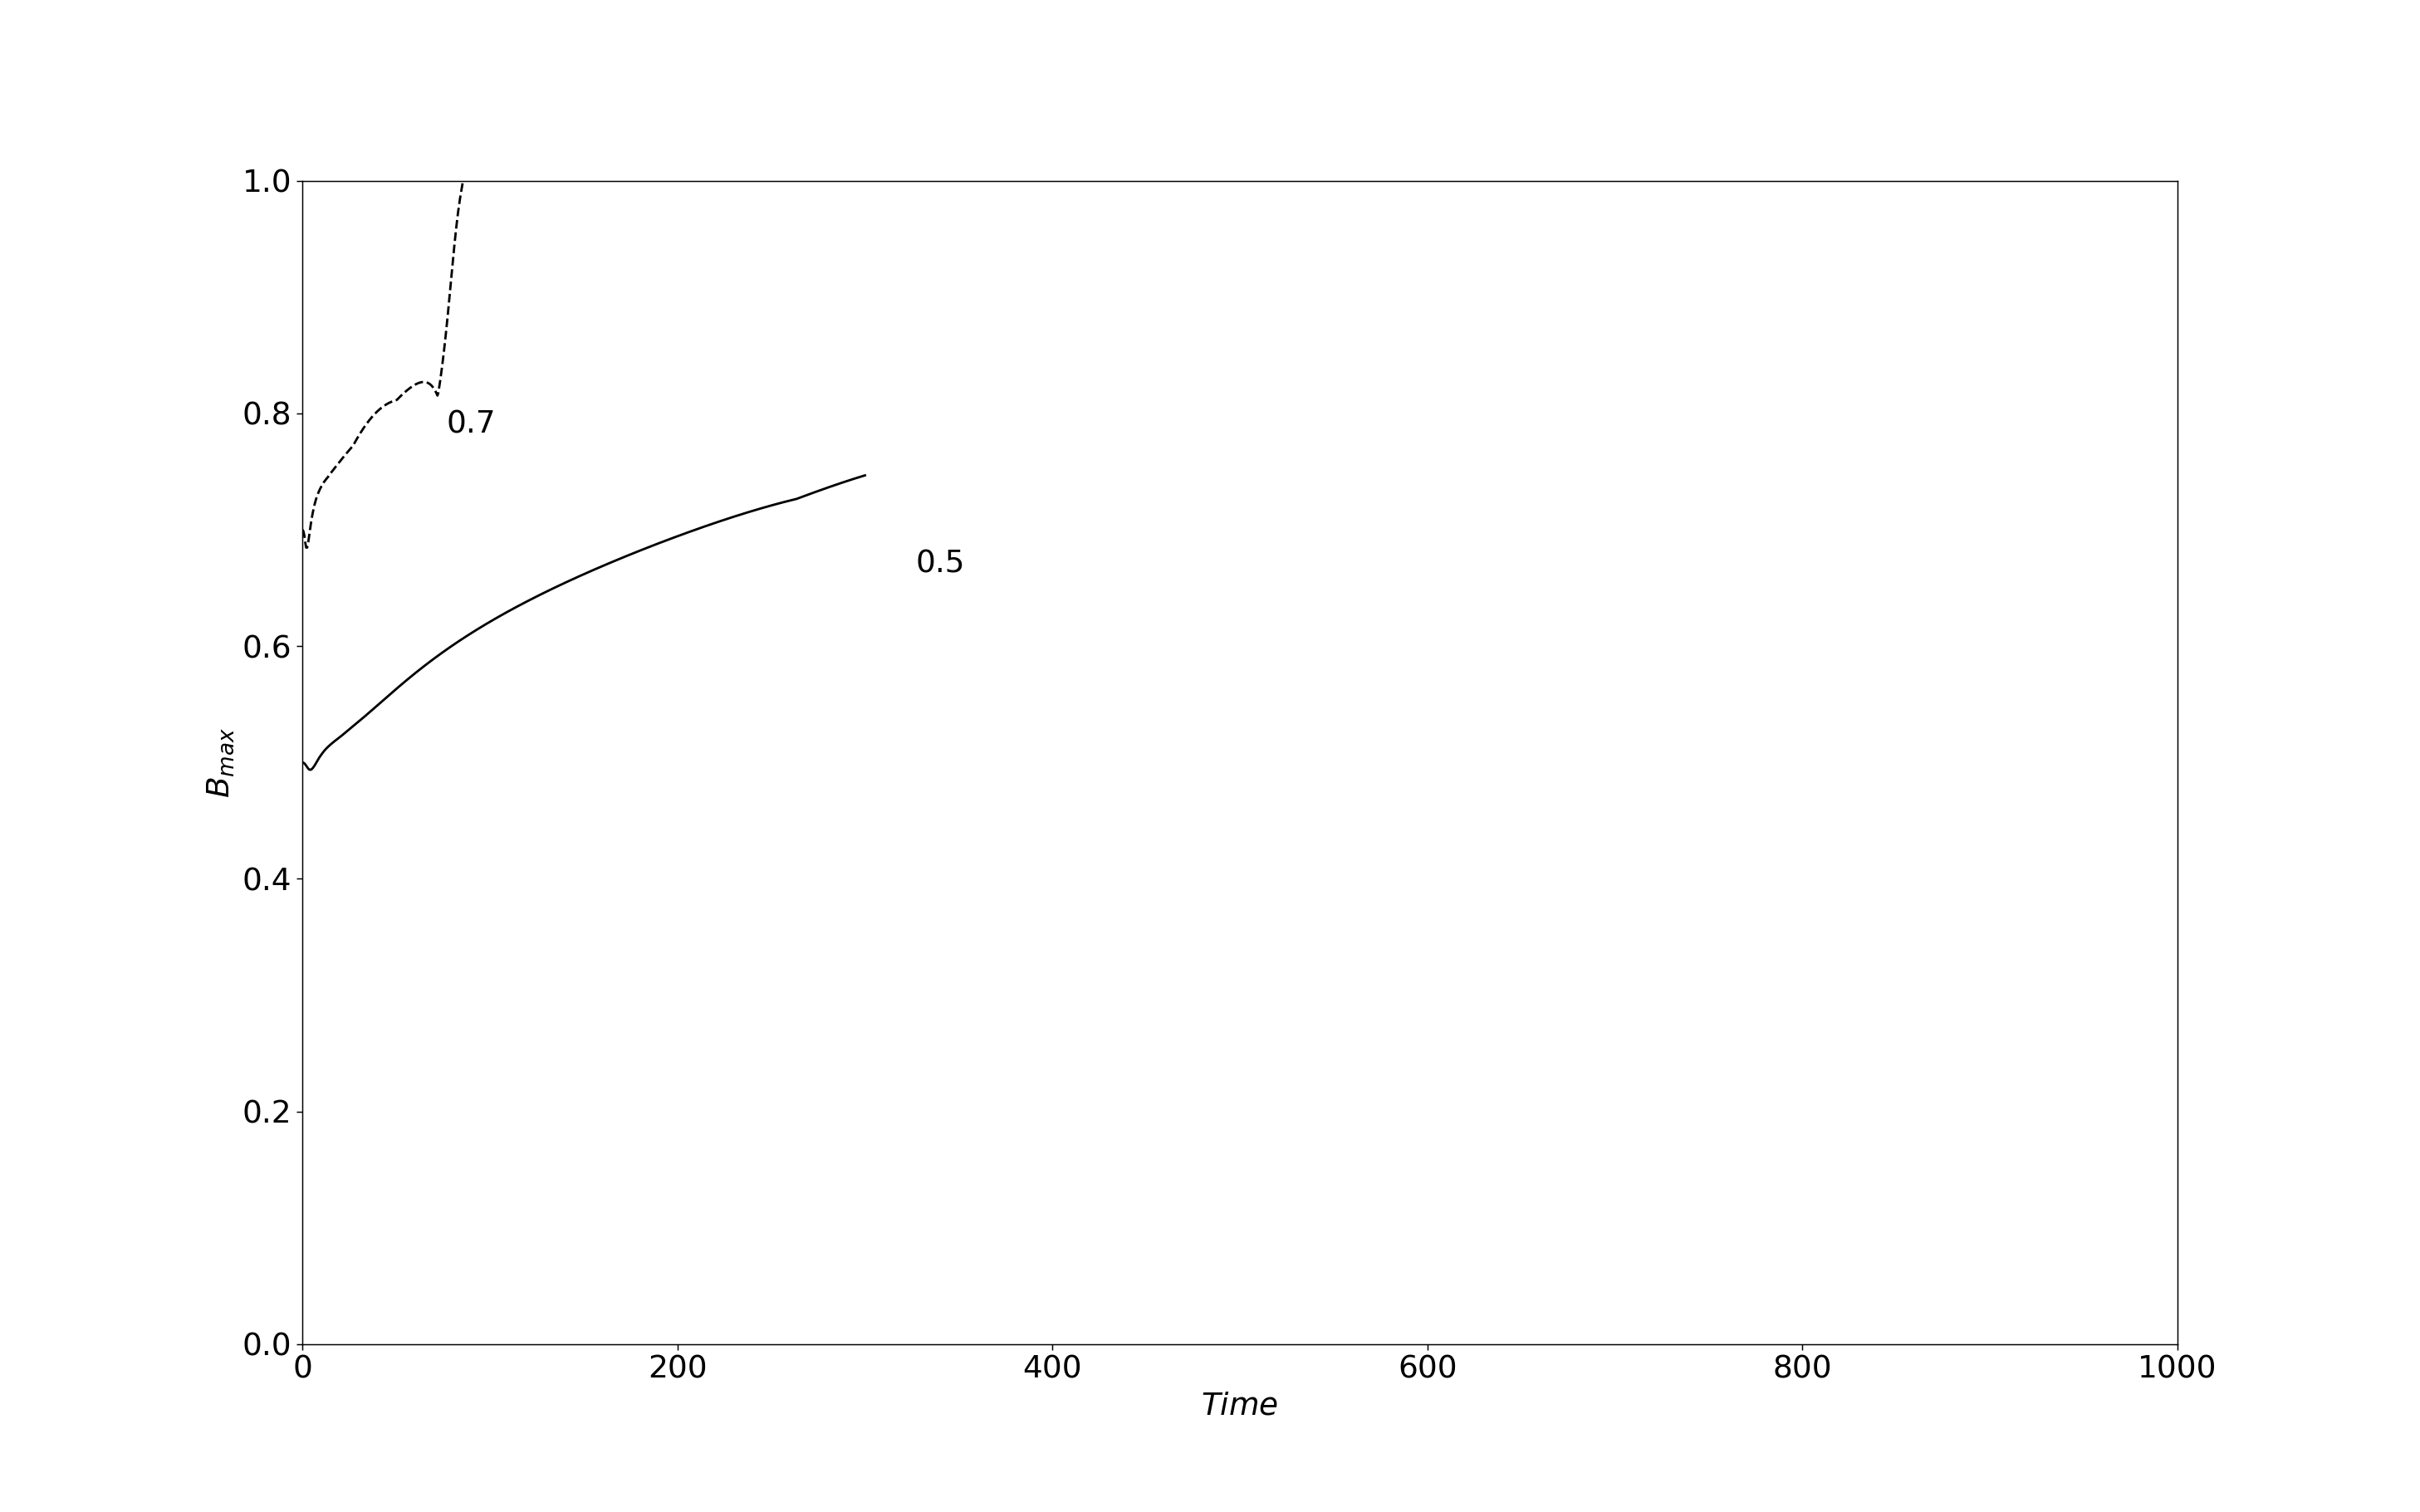

No handles with labels found to put in legend.


In [35]:
### Directories where I have store DF's with Bmax and time

beta = [0.2,  0.223]
BS   = 0.5 
polar= ['RHP wave, β=','LHP wave, β=', ]

dir1           = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\dfs_bmax\_'+polar[1]+str(beta[0])+str(BS)+'.csv'
dir2           = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\dfs_bmax\_LHP_waveb_0.2230.5.csv'
#dir3           = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\dfs_bmax\_'+polar[1]+str(beta[0])+str(BS)+'.csv'
#dir4           = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\dfs_bmax\_'+polar[1]+str(beta[1])+str(BS)+'.csv'
save_folder    = r'C:\Users\nikos.000\MHD1D\figures\jpg\test\_test'

fig = plt.figure( figsize=(16,10))
ax = fig.add_subplot()

B_RHP_2 = pd.read_csv(dir1, sep=',')
B_RHP_8 = pd.read_csv(dir2, sep=',')
#B_LHP_2 = pd.read_csv(dir3, sep=',')
#B_LHP_8 = pd.read_csv(dir4, sep=',')

ax.plot(B_RHP_2['Time'].values,B_RHP_2['Bmax'].values,color='black',ls='-')#,label=polar[0]+str(beta[0]))
ax.plot(B_RHP_8['Time'].values,B_RHP_8['Bmax'].values,color='black',ls= '--')#,label=polar[0]+str(beta[1]))
#ax.plot(B_LHP_2['Time'].values,B_LHP_2['Bmax'].values,color='black',label=polar[1]+str(beta[0]))
#ax.plot(B_LHP_8['Time'].values,B_LHP_8['Bmax'].values,color='black',ls= 'dotted',label=polar[1]+str(beta[1]))

ax.set_ylabel('$B_{max}$', fontsize =20)
ax.set_xlabel('$Time$', fontsize =20)
ax.set_ylim([0,1])
ax.legend(frameon=False,loc=1,fontsize=20) 
ax.tick_params(axis='both',labelsize=20)

### Add text ###

polar= ['LHP, β=','LHP, β=', ]

ax.text(0.09, 0.79,'0.7',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,fontsize =20)



ax.text(0.34, 0.67,'0.5',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,fontsize =20)



ax.set_xlim([0,1000])


fig.show()
fig.savefig(save_folder+'all_four2.jpg', format='jpg',dpi=300,bbox_inches='tight')


### Combine figures

<IPython.core.display.Javascript object>


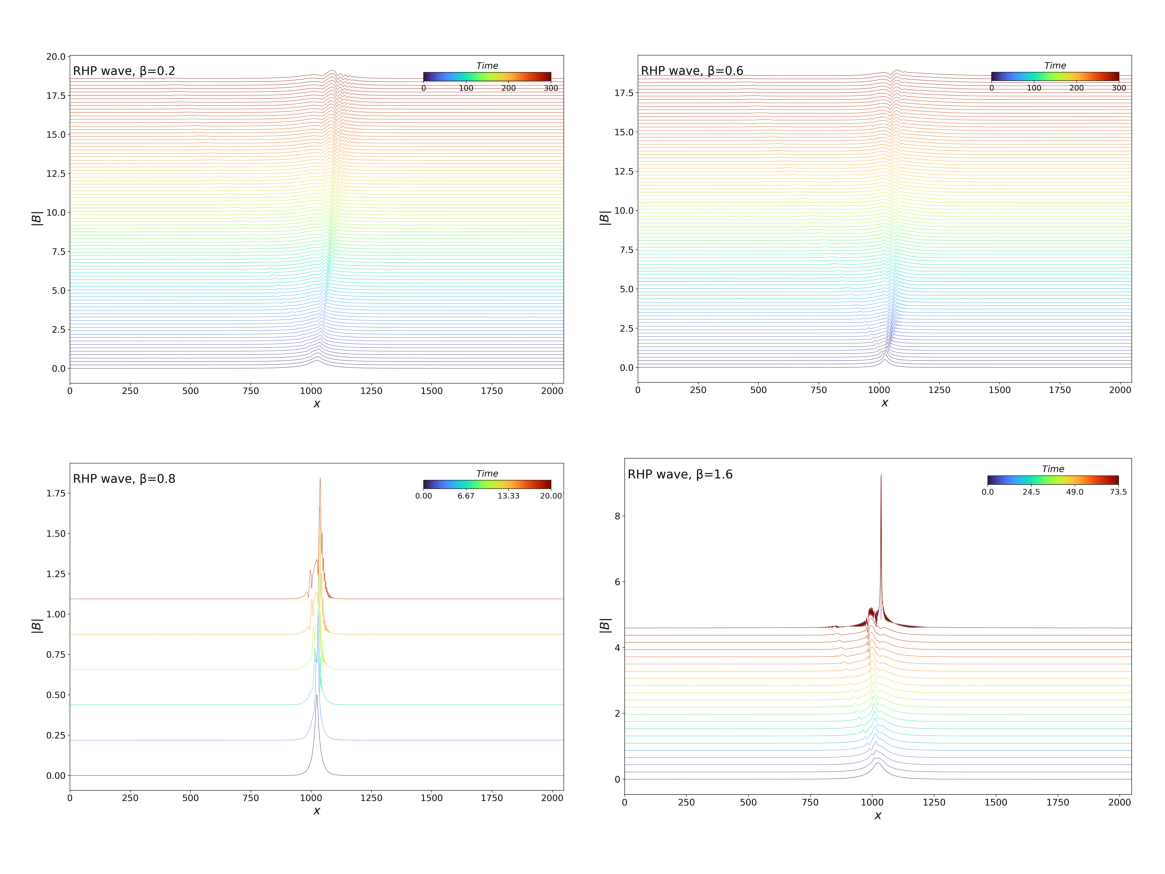

In [499]:
#FIG 12

## FIG9 ##

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


### Change here ###

polari = 'RH'


## get savd pngs ##                                                   

img1 = mpimg.imread(r'C:\Users\nikos.000\MHD1D\figures\jpg\test\_testRHP_waveb_0.20.5.jpg')
img2 = mpimg.imread(r'C:\Users\nikos.000\MHD1D\figures\jpg\test\_testRHP_waveb_0.60.5.jpg')
img3 = mpimg.imread(r'C:\Users\nikos.000\MHD1D\figures\jpg\test\_testRHP_waveb_0.80.5.jpg')
img4 = mpimg.imread(r'C:\Users\nikos.000\MHD1D\figures\jpg\test\_testRHP_waveb_1.60.5.jpg')


size_f=24
labels = ("", "", "", "")
fig = plt.figure()
gs = gridspec.GridSpec(2, 8,wspace=0.01,hspace=0.02)
#gs.update(wspace=0.15)
ax1 = fig.add_subplot(gs[0, :4], )
ax2 = fig.add_subplot(gs[0, 4:])
ax3 = fig.add_subplot(gs[1, :4], )
ax4 = fig.add_subplot(gs[1, 4:])
#ax3 = fig.add_subplot(gs[1, 1:3])
ax1.imshow(img1)
ax1.text(-0.02, 0.95, labels[0], transform=ax1.transAxes, fontsize=13, fontweight='normal', va='top', ha='right')
ax2.imshow(img2)
ax2.text(-0.02, 0.95, labels[1], transform=ax2.transAxes, fontsize=13, fontweight='normal', va='top', ha='right')
ax3.imshow(img3)
ax3.text(-0.02, 0.95, labels[2], transform=ax3.transAxes, fontsize=13, fontweight='normal', va='top', ha='right')
ax4.imshow(img4)
ax4.text(-0.02, 0.95, labels[3], transform=ax4.transAxes, fontsize=13, fontweight='normal', va='top', ha='right')
ax1.axis('off')
ax2.axis('off')

ax3.axis('off')
ax4.axis('off')
#fig.subplots_adjust(wspace=0.03)
#fig.subplots_adjust(hspace=0.03)  
gs.tight_layout(fig)
#fig.tight_layout()
#fig.subplots_adjust(bottom=0.5)
#plt.subplots_adjust(top=0.82, bottom=0.08, left=0.40, right=0.95, hspace=0.05,
                       # wspace=0.05)

fig.savefig(r'C:\Users\nikos.000\MHD1D\figures\jpg\test\combined'+str(polari)+'.jpg', format='jpg',dpi=300,bbox_inches='tight')